In [1]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_and_visu_non_recurrent import evaluate_config,get_ds,train_the_config,get_ds_without_shuffling_on_train_set
from plotting.plotting import error_per_station_calendar_pattern,gain_between_models
from examples.train_model_on_k_fold_validation import load_configuration
from constants.paths import SAVE_DIRECTORY
from high_level_DL_method import load_model,load_optimizer_and_scheduler
from examples.load_best_config import load_args_of_a_specific_trial
from trainer import Trainer
import torch 

def get_trainer_and_ds_from_saved_trial(trial_id,add_name_id,save_folder,modification,fold_to_evaluate = None):
    # Load Data and Init Model:
    if fold_to_evaluate is None:
        fold_name = 'complete_dataset'
    else:
        fold_name = fold_to_evaluate[0]

    #args,_ = load_configuration(trial_id1,load_config=True)
    args = load_args_of_a_specific_trial(trial_id,add_name_id,save_folder,fold_name)

    if fold_to_evaluate is None:  fold_to_evaluate = [args.K_fold-1]

    
           
    ds,_,_,_,_ =  get_ds(args_init=args,modification = modification,fold_to_evaluate=fold_to_evaluate)
    model = load_model(ds, args)


    # Load Trained Weights 
    model_param = torch.load(f"{current_path}/{SAVE_DIRECTORY}/{save_folder}/best_models/{trial_id}{add_name_id}_f{fold_name}.pkl")
    model.load_state_dict(model_param['state_dict'],strict=True)


    # Load Trainer : 
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler)

    return trainer,ds,args


Training and Hyper-parameter tuning with Ray is not possible


# Load Both models to compare : 

In [2]:
modification = {'shuffle':False,
                'data_augmentation':False }

# Load Model1:
save_folder1 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id1 = ''
trial_id1 ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
trainer1,ds1,args1 = get_trainer_and_ds_from_saved_trial(trial_id1,add_name_id1,save_folder1,modification)

# Load Model2: 
#Trained Model with Subway-in / Subway-out 
if False:
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    add_name_id2 = 'concat_early'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

#Trained Model with Subway-in / NetMob POI:
if True: 
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    add_name_id2 = 'NETMOB_POIS_maps_Twitter_concat_early_late_UL_DL_all_tags'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 


Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40

## Get Metrics from trained model. Compared consistency with saved one : 
Nous permets de nous assurer qu'on à bien sauvegarder le meiolleur model, et que c'est bien celui qu'on Load.

In [3]:
def display_consistency(trainer,ds,save_folder,trial_id,add_name_id,training_mode = 'test'):
    full_predict1,Y_true,_ = trainer.testing(ds.normalizer, training_mode =training_mode)
    Y_true= Y_true.detach().clone().reshape(-1)    
    full_predict1= full_predict1.detach().clone().reshape(-1)    
    error_pred1 = ((Y_true - full_predict1)**2).mean()

    df_metrics1 = pd.read_csv(f"{current_path}/{SAVE_DIRECTORY}/{save_folder}/METRICS_{trial_id}{add_name_id}.csv")
    display(df_metrics1)
    print(f"MSE errror on {training_mode} by loading trained model : {'{:.2f}'.format(error_pred1.item())}")

if True:
    display_consistency(trainer2,ds2,save_folder2,trial_id2,add_name_id2,training_mode = 'test')

,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1324.763184,21.642506,36.200874,7944.388301,0.436605,10.932614,1250.250854,21.195671,32.322041
1,test,1366.276001,21.950677,34.394472,4432.022240,0.823113,35.609372,1338.346436,21.048252,26.952559


MSE errror on test by loading trained model : 1338.35


## Plot Gains between Two trained Models:
Retourne le gain de Model 2 par rapport à Model 1

In [22]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from plotting.plotting import get_gain_from_mod1,build_matrix_for_matshow,plot_matshow,plot_coverage_matshow

def plot_gains(ds1,column,station_ind,training_mode,dict_error,freq,index_matshow,columns_matshow, metrics,v_min,v_max,cmap,bool_reversed,axes):
    for ind_metric,metric_i in enumerate(metrics) : 
        cbar_label = f"Gain {metric_i}"
        # Build Matshow matrix : 
        df_agg = build_matrix_for_matshow(ds1,column,training_mode,dict_error[metric_i],freq,index_matshow,columns_matshow)

        # Plotting : 
        plot_matshow(df_agg,column,metric_i,v_min,v_max,cmap,cbar_label,bool_reversed,axes,station_ind,ind_metric)      

def gain_between_models(trainer1,trainer2,ds1,ds2,training_mode,
                         metrics = ['mse','mae','mape'],
                        freq='1h',
                        index_matshow = 'day_date',
                        columns_matshow = 'hour',
                        min_flow = 20,
                        figsize = (20,20),
                        limit_percentage_error = 300,
                        acceptable_error = 10,
                        stations = None,
                        plot_each_station = False,
                        plot_all_station = True

                         ):
    '''

    '''
    # Init:
    if stations is not None:
        n_station = len(stations) 
    else:
        n_station = len(ds1.spatial_unit)
        stations = list(ds1.spatial_unit)

    nb_station_to_plots = plot_each_station*n_station + plot_all_station
    fig, axes = plt.subplots(nb_station_to_plots, len(metrics), figsize=figsize)

    # Get Pred1,Pred2, TrueValues:
    full_predict1,Y_true,_ = trainer1.testing(ds1.normalizer, training_mode =training_mode)
    full_predict2,_,_ = trainer2.testing(ds2.normalizer, training_mode =training_mode)

    # Set cmap:
    cmap = 'RdYlBu'
    bool_reversed = True
    v_min,v_max = -limit_percentage_error,limit_percentage_error

    # Evaluate Prediciton per stations:
    if plot_each_station:
        for station_ind in range(n_station):
            station_c = list(ds1.spatial_unit).index(stations[station_ind])
            column = stations[station_ind]

            dict_error = get_gain_from_mod1(real = Y_true[:,station_c:station_c+1,:],
                                        predict1 = full_predict1[:,station_c:station_c+1,:],
                                        predict2 = full_predict2[:,station_c:station_c+1,:],
                                        min_flow=min_flow,limit_percentage_error=limit_percentage_error,metrics = metrics,acceptable_error= acceptable_error) 
            plot_gains(ds1,column,station_ind,training_mode,dict_error,freq,index_matshow,columns_matshow, metrics,v_min,v_max,cmap,bool_reversed,axes)

    if plot_all_station:
        station_ind = n_station if plot_each_station else 1
        column = 'All'
        T,N,C = Y_true.size()
        dict_error = get_gain_from_mod1(real =Y_true,
                                    predict1 = full_predict1,
                                    predict2 = full_predict2,
                                    min_flow=min_flow,limit_percentage_error=limit_percentage_error,metrics = metrics,acceptable_error= acceptable_error)
        dict_error = {metric_i:error_i.reshape(T,N).mean(axis=1) for metric_i,error_i in dict_error.items()}
        plot_gains(ds1,column,station_ind,training_mode,dict_error,freq,index_matshow,columns_matshow, metrics,v_min,v_max,cmap,bool_reversed,axes)



    plt.tight_layout()
    plt.show()
    return fig,axes

def plot_matshow(df_agg,column,metric,v_min,v_max,cmap,cbar_label,bool_reversed,axes,station_c,ind_metric):
    ''' Plotting function for 'error_per_station_calendar_pattern' '''
    if len(axes.shape)==1:
        plt.sca(axes[ind_metric])
    else:
        plt.sca(axes[station_c,ind_metric])       
    plot_coverage_matshow(df_agg, log=False, cmap=cmap, save=None, cbar_label=cbar_label,bool_reversed=bool_reversed,v_min=v_min,v_max=v_max)

    if metric == 'previous_value':
        title = f"Gain (%) of MSE error compared to using previous value as prediction"
    else : 
        title = f"{metric} error on station {column}"  
    if len(axes.shape)==1:     
        axes[ind_metric].set_title(title)
    else:     
        axes[station_c,ind_metric].set_title(title)

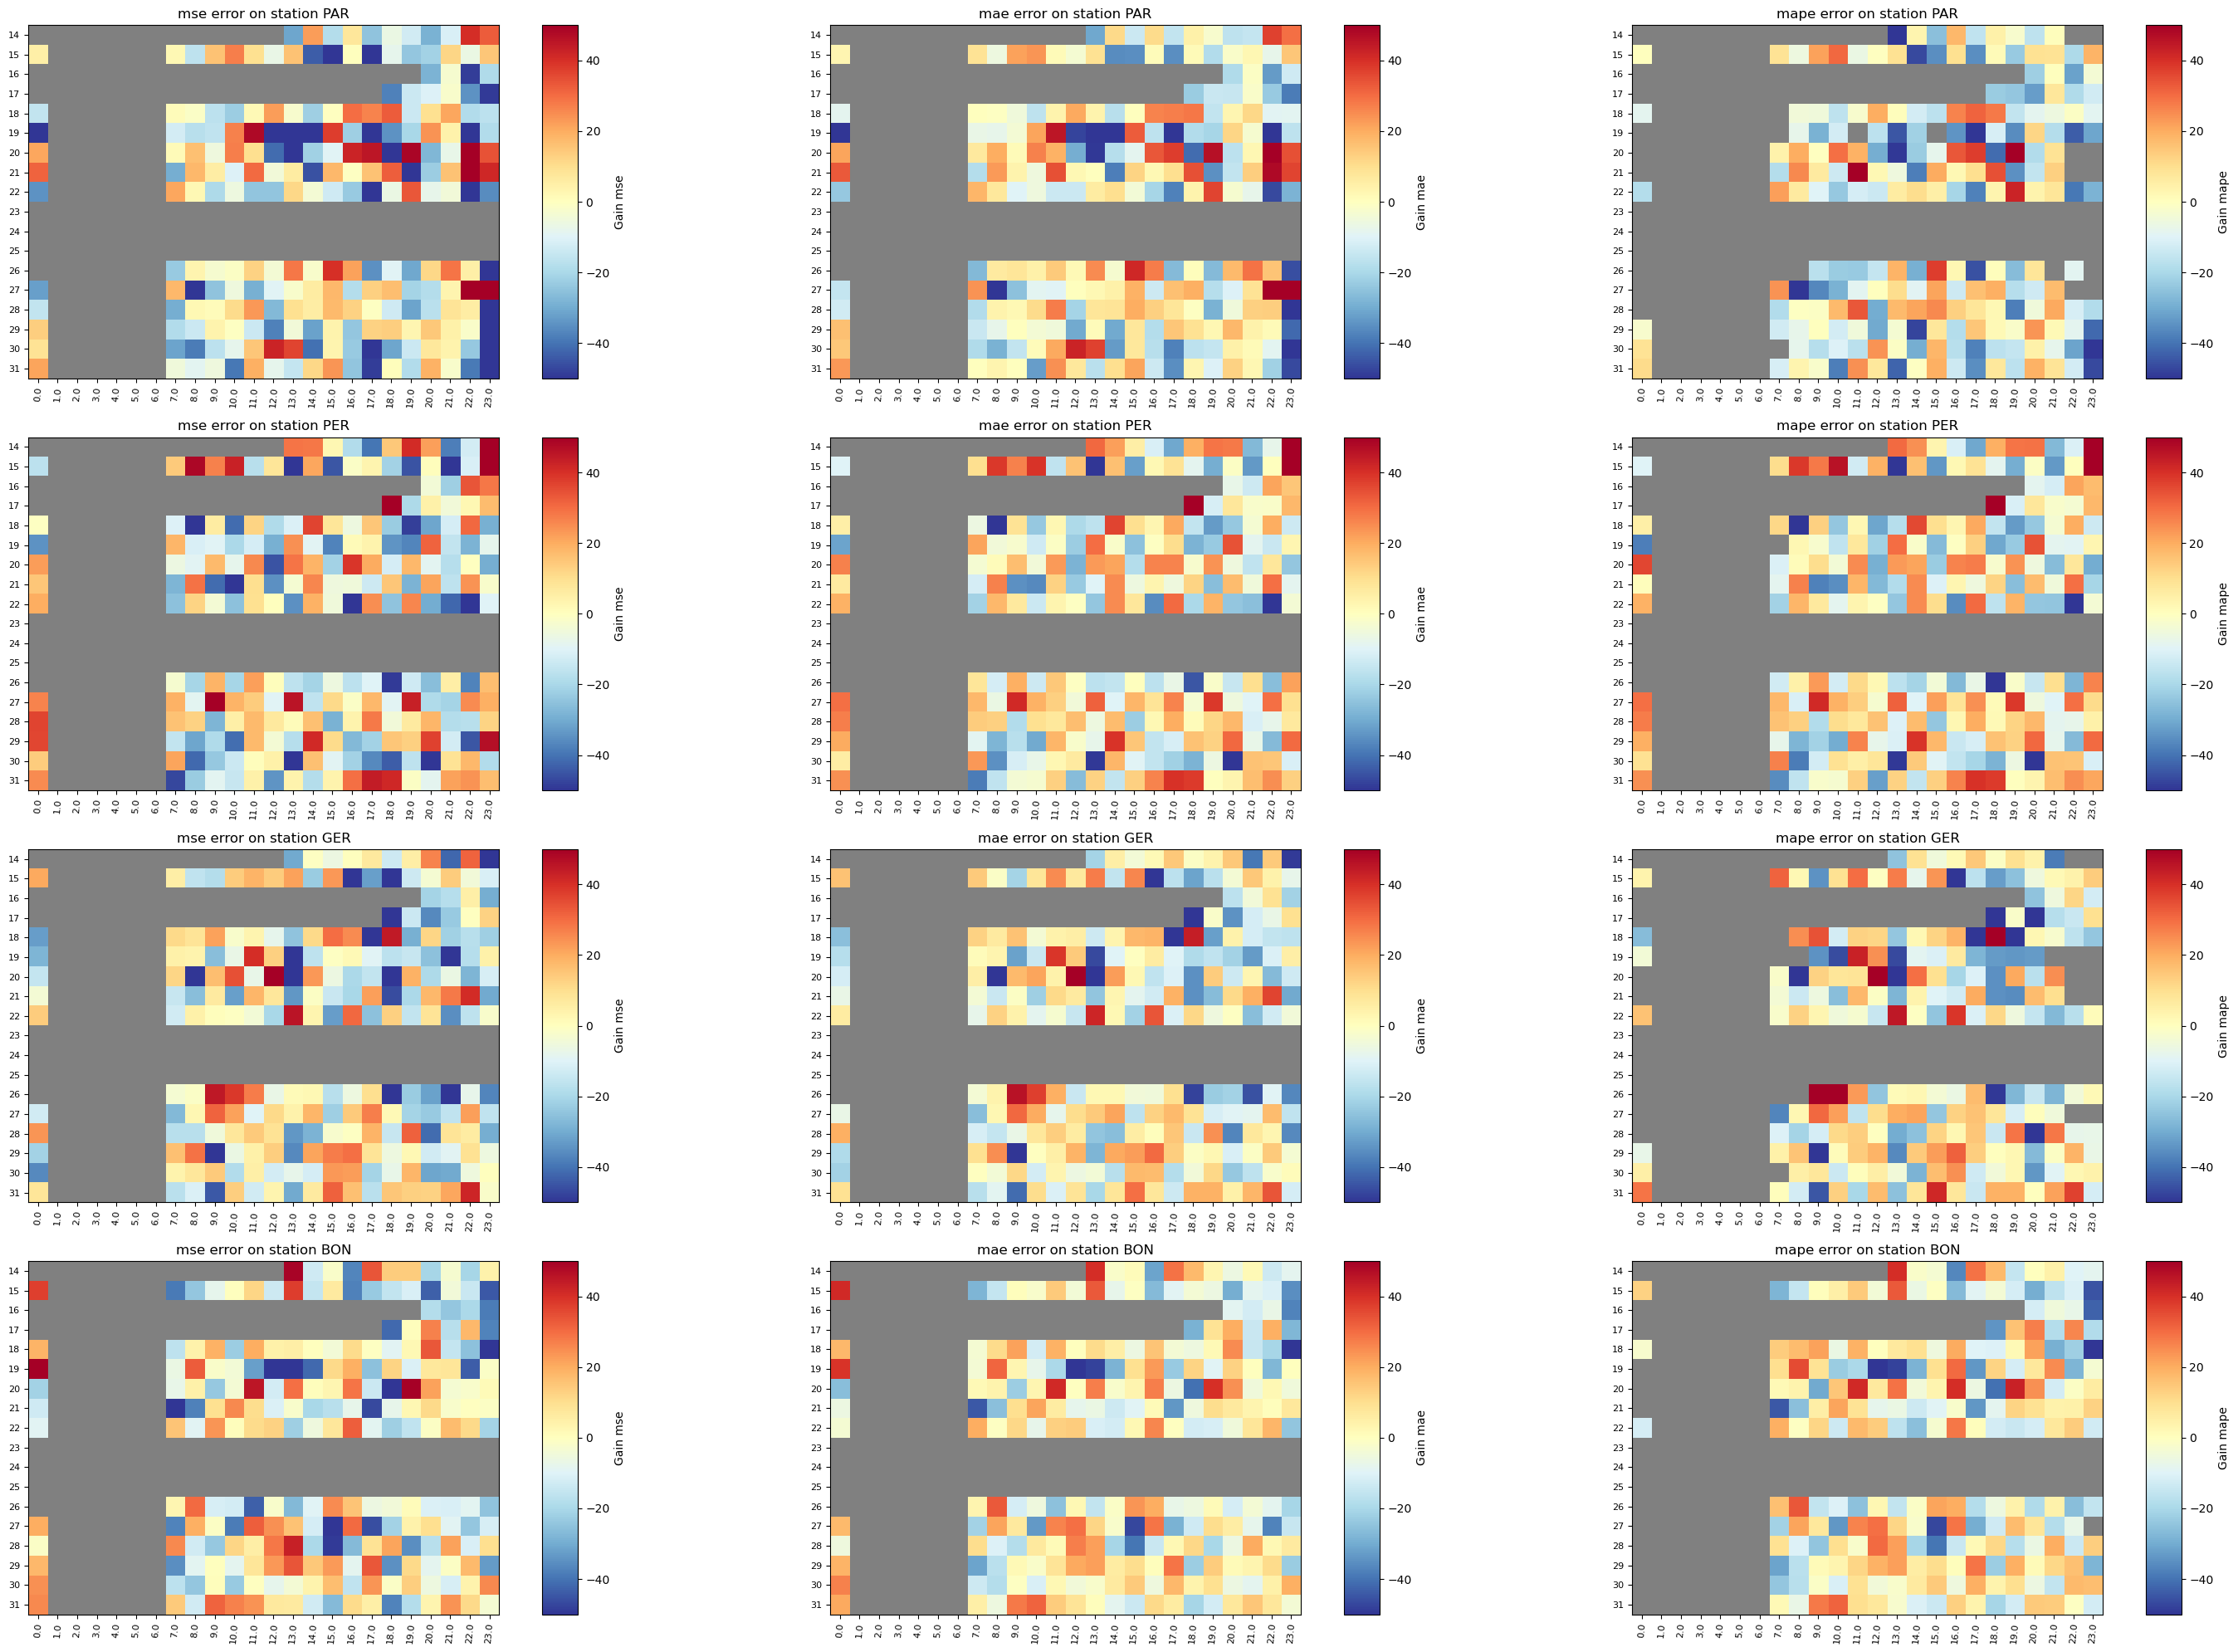

(<Figure size 3000x2000 with 24 Axes>,
 array([[<Axes: title={'center': 'mse error on station PAR'}>,
         <Axes: title={'center': 'mae error on station PAR'}>,
         <Axes: title={'center': 'mape error on station PAR'}>],
        [<Axes: title={'center': 'mse error on station PER'}>,
         <Axes: title={'center': 'mae error on station PER'}>,
         <Axes: title={'center': 'mape error on station PER'}>],
        [<Axes: title={'center': 'mse error on station GER'}>,
         <Axes: title={'center': 'mae error on station GER'}>,
         <Axes: title={'center': 'mape error on station GER'}>],
        [<Axes: title={'center': 'mse error on station BON'}>,
         <Axes: title={'center': 'mae error on station BON'}>,
         <Axes: title={'center': 'mape error on station BON'}>]],
       dtype=object))

In [25]:
station = ['PAR','PER','GER','BON']
training_mode = 'test'
gain_between_models(trainer1,trainer2,ds1,ds2,training_mode,
                         metrics = ['mse','mae','mape'],
                        freq='1h',
                        index_matshow = 'day_date',
                        columns_matshow = 'hour',
                        min_flow = 20,
                        figsize = (30,5*len(station)),
                        limit_percentage_error = 50,
                        acceptable_error = 10,
                        stations = station,
                        plot_each_station = True,
                        plot_all_station = True)

## Visualisation des coeff d'attentions :

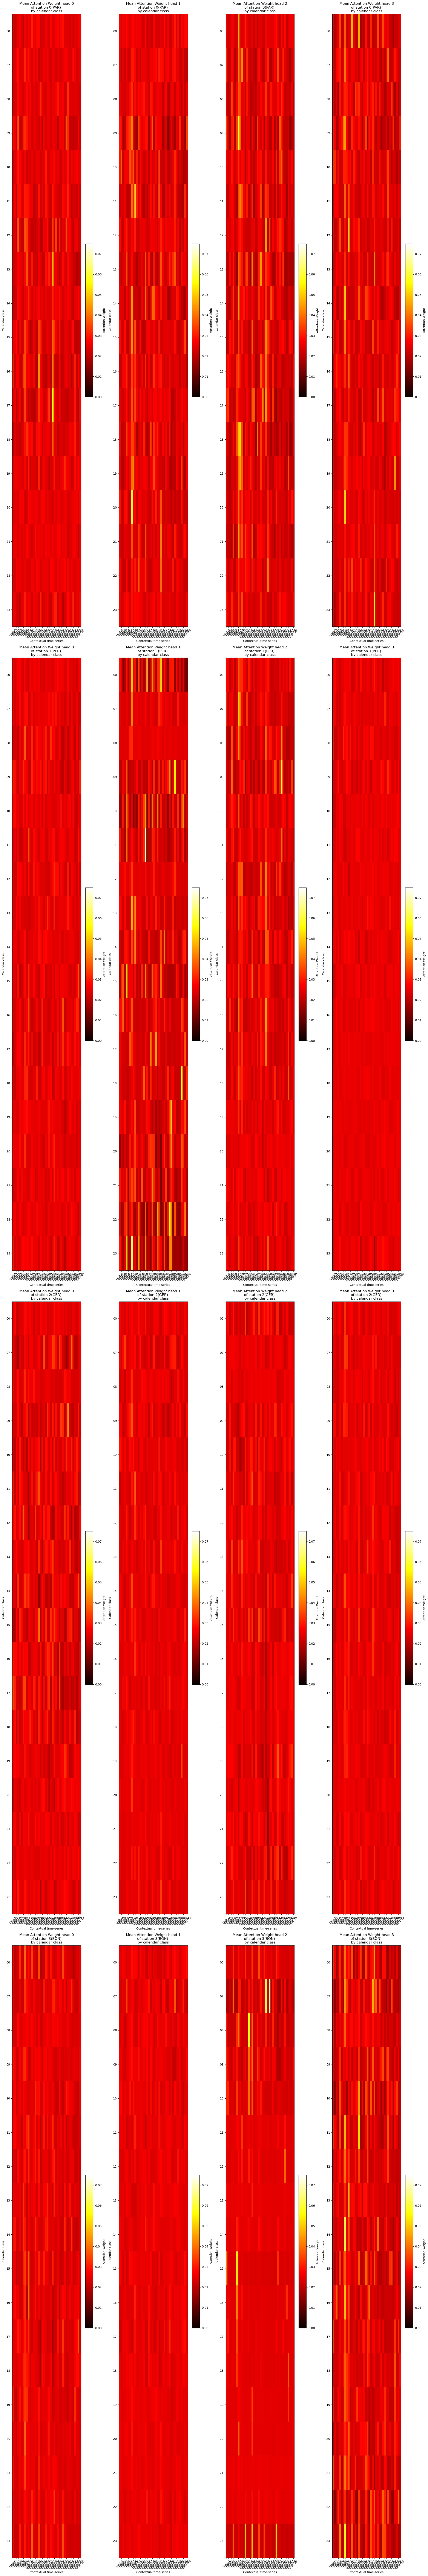

In [39]:
from plotting.plotting import plot_attn_weight
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)
temporal_agg = 'hour'  # weekday_hour_minutes','hour','weekday','weekday_hour'
plot_attn_weight(trainer2,nb_calendar_data,ds1,training_mode = training_mode,stations= station,temporal_agg =temporal_agg,save=None)